In [1]:
#Oluwatoni Obembe
#Load libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

In [2]:
#Load data
intensity_data = pd.read_csv('Processed_carbon_forecast.csv',index_col='time')
model_data = intensity_data.drop(['intensity.forecast','intensity.index','Fossil_like_share','Low_carbon_share','imports','2hr_rolling_from_2hrs_ago','2hr_rolling_from_1d_ago'],axis=1)

In [3]:
#Setting up train, validation and test splits since time series not using random
#Can't train on future data to predict the past
train = model_data[:'2024-06-03']
val = model_data['2024-05-04':'2024-05-13']
test = model_data['2024-05-14':]

In [4]:
#Pick inputs and targets
X_train = train.drop('intensity.actual', axis=1)
y_train = train['intensity.actual']

X_val = val.drop('intensity.actual', axis=1)
y_val = val['intensity.actual']

X_test = test.drop('intensity.actual', axis=1)
y_test = test['intensity.actual']

In [5]:
#Setting up the model, large n_estimators early stopping will cut back
base=y_train.mean()

base_model = XGBRegressor(
    base_score = base,
    objective = 'reg:squarederror', #Minimise error
    n_estimators =5000,
    tree_method='hist', #Probably could have used exact as not large dataset
    eval_metric = 'rmse',
    early_stopping_rounds=50,
    verbosity = 0
)

In [6]:
#Need uniform
from scipy.stats import uniform
from scipy.stats import randint
from scipy.stats import loguniform

#Set up search space of hyperparameter
param_dist = {
    'learning_rate': uniform(0.02, 0.20), #Correction from previous errors
    'max_depth': randint(3, 12), #Depth of trees if too high may overfit
    'min_child_weight': randint(1, 12),     
    'subsample': uniform(0.5, 0.5), #Fraction of rows used for trees
    'colsample_bytree': uniform(0.3, 0.7), #Help prevent overreliance on a feature   
    'gamma': uniform(0, 3), #Minimum loss reduction to make a split 
    'reg_alpha': loguniform(1e-3, 1), #Shrink less important feature weights   
    'reg_lambda': loguniform(1e-2, 10) # Helps keep weights small
}


#Randomised search CV, used to find the best hyperparameters to build model
rs_cv = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    n_iter=30,                 
    scoring='neg_root_mean_squared_error',
    cv=3,                 
    random_state=25,
    n_jobs=-1,                  # use all CPU cores
    verbose=1,
    return_train_score=False
)

In [7]:
#Fit the data
rs_cv.fit(X_train, y_train,eval_set=[(X_val,y_val)], verbose=True)

#Results and save best model
print('Best CV RMSE: ', -rs_cv.best_score_)
print('Best params: ', rs_cv.best_params_)
best_model = rs_cv.best_estimator_
best_model.save_model('xgb_carbon_model.json')

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[0]	validation_0-rmse:46.41771
[1]	validation_0-rmse:42.95574
[2]	validation_0-rmse:39.90513
[3]	validation_0-rmse:37.20203
[4]	validation_0-rmse:35.09707
[5]	validation_0-rmse:33.05491
[6]	validation_0-rmse:30.78060
[7]	validation_0-rmse:28.71015
[8]	validation_0-rmse:27.87984
[9]	validation_0-rmse:26.06493
[10]	validation_0-rmse:24.99498
[11]	validation_0-rmse:23.76042
[12]	validation_0-rmse:22.26593
[13]	validation_0-rmse:21.32477
[14]	validation_0-rmse:20.03398
[15]	validation_0-rmse:19.02705
[16]	validation_0-rmse:18.86654
[17]	validation_0-rmse:17.87742
[18]	validation_0-rmse:17.15204
[19]	validation_0-rmse:16.32110
[20]	validation_0-rmse:15.52147
[21]	validation_0-rmse:15.00859
[22]	validation_0-rmse:14.20429
[23]	validation_0-rmse:13.65529
[24]	validation_0-rmse:12.90983
[25]	validation_0-rmse:12.29821
[26]	validation_0-rmse:12.14922
[27]	validation_0-rmse:12.01585
[28]	validation_0-rmse:11.89614
[29]	validation_0-rms

[257]	validation_0-rmse:1.23275
[258]	validation_0-rmse:1.23271
[259]	validation_0-rmse:1.23273
[260]	validation_0-rmse:1.23273
[261]	validation_0-rmse:1.23275
[262]	validation_0-rmse:1.23275
[263]	validation_0-rmse:1.23275
[264]	validation_0-rmse:1.23277
[265]	validation_0-rmse:1.23278
[266]	validation_0-rmse:1.23278
[267]	validation_0-rmse:1.23280
[268]	validation_0-rmse:1.23283
[269]	validation_0-rmse:1.23287
[270]	validation_0-rmse:1.23288
[271]	validation_0-rmse:1.23291
[272]	validation_0-rmse:1.23288
[273]	validation_0-rmse:1.23289
[274]	validation_0-rmse:1.23294
[275]	validation_0-rmse:1.21567
[276]	validation_0-rmse:1.21565
[277]	validation_0-rmse:1.21560
[278]	validation_0-rmse:1.21561
[279]	validation_0-rmse:1.21559
[280]	validation_0-rmse:1.21557
[281]	validation_0-rmse:1.21556
[282]	validation_0-rmse:1.21556
[283]	validation_0-rmse:1.21557
[284]	validation_0-rmse:1.21558
[285]	validation_0-rmse:1.21560
[286]	validation_0-rmse:1.21560
[287]	validation_0-rmse:1.21563
[288]	va

In [8]:
#Evaluate on test data
from sklearn.metrics import mean_squared_error

y_pred = best_model.predict(X_test)
rmse_test = mean_squared_error(y_test,y_pred,squared=False)
print('Test RMSE: ', rmse_test)

Test RMSE:  1.2341446461660366


In [9]:
#Will compared rmse of forecast to tje predictions
test_set = intensity_data['2024-05-14':]
rmse_forecast = mean_squared_error(y_test, test_set['intensity.forecast'], squared=False)
print('Forecast RMSE:   ', rmse_forecast)

Forecast RMSE:    13.063945294843617


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8322 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8322 missing from current font.
  font.set_text(s, 0, flags=flags)


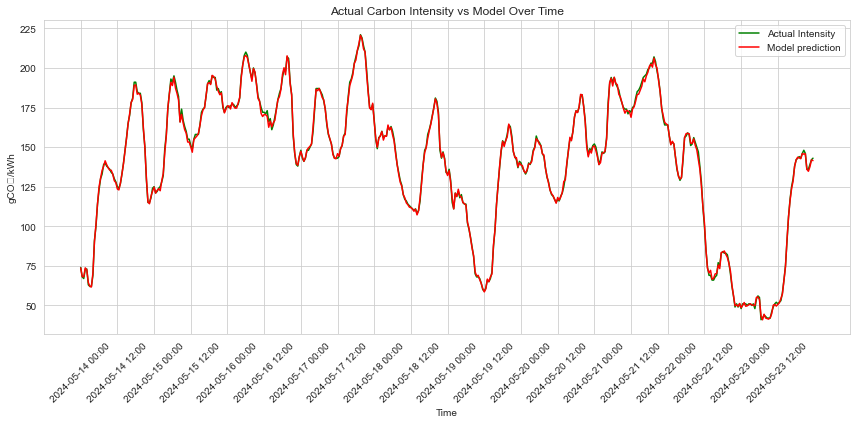

In [10]:
# Set Seaborn style
sns.set_style('whitegrid')

test_set.index = pd.to_datetime(test_set.index)#Currently index isn't datetime

# Plot lines
fig,ax = plt.subplots(figsize=(12, 6))
sns.lineplot(x=test_set.index, y='intensity.actual', data=test, label='Actual Intensity', color='green',ax=ax)
sns.lineplot(x=test_set.index, y=y_pred, label = 'Model prediction', color='red',ax=ax)

import matplotlib.dates as mdates

xticks = test_set.index[::24] # every 12 hours

# Set ticks and formatted tick labels
ax.set_xticks(xticks)
ax.set_xticklabels([ts.strftime('%Y-%m-%d %H:%M') for ts in xticks], rotation=45)

# Label the plot
plt.title('Actual Carbon Intensity vs Model Over Time')
plt.xlabel('Time')
plt.ylabel('gCO₂/kWh')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

 99%|===================| 2803/2829 [00:55<00:00]        

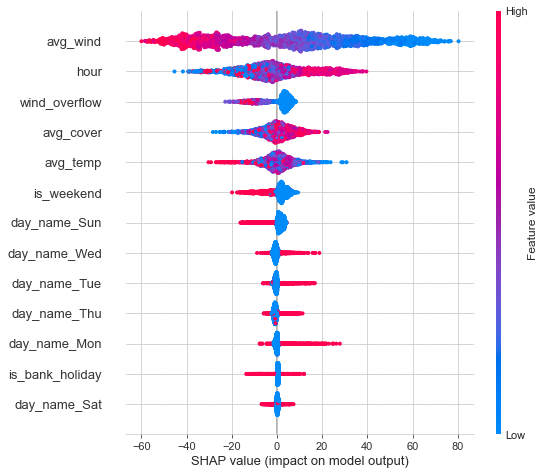

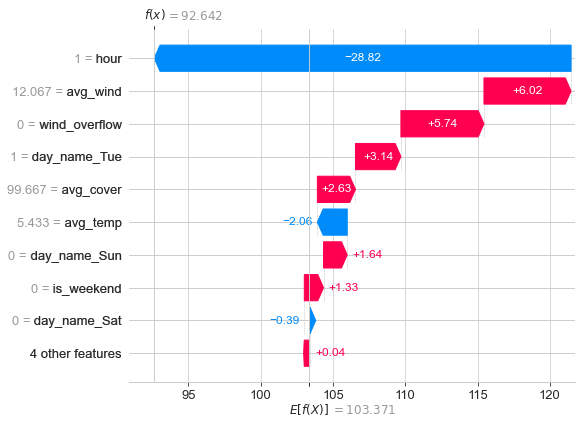

In [11]:
import shap

# Explain the model predictions using SHAP
explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_train)

# Summary plot (global importance)
shap.summary_plot(shap_values, X_train)
plt.savefig('shap_summary.png', dpi=300, bbox_inches='tight')
plt.close()

# Waterfall plot for a single prediction
shap.plots.waterfall(shap_values[0])
plt.savefig('shap_waterfall.png', dpi=300, bbox_inches='tight')
plt.close()

In [12]:
#Going to add lagging data and see how affects model

ldata = intensity_data.drop(['intensity.forecast','intensity.index','Fossil_like_share','Low_carbon_share','imports'],axis=1)

ltrain = ldata[:'2024-06-03']
lval = ldata['2024-05-04':'2024-05-13']
ltest = ldata['2024-05-14':]

X_ltrain = ltrain.drop('intensity.actual', axis=1)
y_ltrain = ltrain['intensity.actual']

X_lval = lval.drop('intensity.actual', axis=1)
y_lval = lval['intensity.actual']

X_ltest = ltest.drop('intensity.actual', axis=1)
y_ltest = ltest['intensity.actual']

In [13]:
#Fit the data with laggs
rs_cv.fit(X_ltrain, y_ltrain,eval_set=[(X_lval,y_lval)], verbose=True)

#Results and save best model
print('Best CV RMSE: ', -rs_cv.best_score_)
print('Best params: ', rs_cv.best_params_)
best_lmodel = rs_cv.best_estimator_
best_lmodel.save_model('xgb_carbon_model_with_lag.json')

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[0]	validation_0-rmse:47.32069
[1]	validation_0-rmse:45.23237
[2]	validation_0-rmse:43.06616
[3]	validation_0-rmse:41.01546
[4]	validation_0-rmse:39.38160
[5]	validation_0-rmse:37.42997
[6]	validation_0-rmse:35.92268
[7]	validation_0-rmse:34.65589
[8]	validation_0-rmse:33.57940
[9]	validation_0-rmse:32.40879
[10]	validation_0-rmse:31.49654
[11]	validation_0-rmse:30.55793
[12]	validation_0-rmse:29.71176
[13]	validation_0-rmse:28.84045
[14]	validation_0-rmse:27.98338
[15]	validation_0-rmse:27.31925
[16]	validation_0-rmse:26.42698
[17]	validation_0-rmse:25.52900
[18]	validation_0-rmse:24.84384
[19]	validation_0-rmse:23.96110
[20]	validation_0-rmse:23.23452
[21]	validation_0-rmse:22.60681
[22]	validation_0-rmse:22.30009
[23]	validation_0-rmse:21.75493
[24]	validation_0-rmse:21.39596
[25]	validation_0-rmse:21.14474
[26]	validation_0-rmse:20.68305
[27]	validation_0-rmse:20.11229
[28]	validation_0-rmse:19.71489
[29]	validation_0-rms

[255]	validation_0-rmse:6.09595
[256]	validation_0-rmse:6.08618
[257]	validation_0-rmse:6.08303
[258]	validation_0-rmse:6.07655
[259]	validation_0-rmse:6.06588
[260]	validation_0-rmse:6.06352
[261]	validation_0-rmse:6.04467
[262]	validation_0-rmse:6.02631
[263]	validation_0-rmse:6.01809
[264]	validation_0-rmse:6.00312
[265]	validation_0-rmse:5.99887
[266]	validation_0-rmse:5.99643
[267]	validation_0-rmse:5.99064
[268]	validation_0-rmse:5.98646
[269]	validation_0-rmse:5.98143
[270]	validation_0-rmse:5.97024
[271]	validation_0-rmse:5.96640
[272]	validation_0-rmse:5.96019
[273]	validation_0-rmse:5.95530
[274]	validation_0-rmse:5.95426
[275]	validation_0-rmse:5.94398
[276]	validation_0-rmse:5.94247
[277]	validation_0-rmse:5.93815
[278]	validation_0-rmse:5.94123
[279]	validation_0-rmse:5.92873
[280]	validation_0-rmse:5.92575
[281]	validation_0-rmse:5.91054
[282]	validation_0-rmse:5.90222
[283]	validation_0-rmse:5.87785
[284]	validation_0-rmse:5.86345
[285]	validation_0-rmse:5.82555
[286]	va

[512]	validation_0-rmse:3.99901
[513]	validation_0-rmse:3.98819
[514]	validation_0-rmse:3.97392
[515]	validation_0-rmse:3.97201
[516]	validation_0-rmse:3.96878
[517]	validation_0-rmse:3.96657
[518]	validation_0-rmse:3.96021
[519]	validation_0-rmse:3.95657
[520]	validation_0-rmse:3.94750
[521]	validation_0-rmse:3.93106
[522]	validation_0-rmse:3.92807
[523]	validation_0-rmse:3.92282
[524]	validation_0-rmse:3.92276
[525]	validation_0-rmse:3.91911
[526]	validation_0-rmse:3.91336
[527]	validation_0-rmse:3.91315
[528]	validation_0-rmse:3.90536
[529]	validation_0-rmse:3.90872
[530]	validation_0-rmse:3.89765
[531]	validation_0-rmse:3.88971
[532]	validation_0-rmse:3.88084
[533]	validation_0-rmse:3.87066
[534]	validation_0-rmse:3.87174
[535]	validation_0-rmse:3.86793
[536]	validation_0-rmse:3.85921
[537]	validation_0-rmse:3.85102
[538]	validation_0-rmse:3.84497
[539]	validation_0-rmse:3.84579
[540]	validation_0-rmse:3.82875
[541]	validation_0-rmse:3.82416
[542]	validation_0-rmse:3.81285
[543]	va

[769]	validation_0-rmse:2.78606
[770]	validation_0-rmse:2.78520
[771]	validation_0-rmse:2.78366
[772]	validation_0-rmse:2.77799
[773]	validation_0-rmse:2.77459
[774]	validation_0-rmse:2.76821
[775]	validation_0-rmse:2.76827
[776]	validation_0-rmse:2.76484
[777]	validation_0-rmse:2.76051
[778]	validation_0-rmse:2.76063
[779]	validation_0-rmse:2.75868
[780]	validation_0-rmse:2.75604
[781]	validation_0-rmse:2.75677
[782]	validation_0-rmse:2.75350
[783]	validation_0-rmse:2.75301
[784]	validation_0-rmse:2.74904
[785]	validation_0-rmse:2.74231
[786]	validation_0-rmse:2.73398
[787]	validation_0-rmse:2.72649
[788]	validation_0-rmse:2.71726
[789]	validation_0-rmse:2.70936
[790]	validation_0-rmse:2.70715
[791]	validation_0-rmse:2.70539
[792]	validation_0-rmse:2.70000
[793]	validation_0-rmse:2.69354
[794]	validation_0-rmse:2.68208
[795]	validation_0-rmse:2.68046
[796]	validation_0-rmse:2.67885
[797]	validation_0-rmse:2.67087
[798]	validation_0-rmse:2.66998
[799]	validation_0-rmse:2.66858
[800]	va

[1025]	validation_0-rmse:2.07840
[1026]	validation_0-rmse:2.07862
[1027]	validation_0-rmse:2.07831
[1028]	validation_0-rmse:2.07812
[1029]	validation_0-rmse:2.06802
[1030]	validation_0-rmse:2.06643
[1031]	validation_0-rmse:2.06611
[1032]	validation_0-rmse:2.06440
[1033]	validation_0-rmse:2.06284
[1034]	validation_0-rmse:2.06202
[1035]	validation_0-rmse:2.05996
[1036]	validation_0-rmse:2.05821
[1037]	validation_0-rmse:2.05602
[1038]	validation_0-rmse:2.05090
[1039]	validation_0-rmse:2.04990
[1040]	validation_0-rmse:2.04709
[1041]	validation_0-rmse:2.04569
[1042]	validation_0-rmse:2.04528
[1043]	validation_0-rmse:2.04484
[1044]	validation_0-rmse:2.03999
[1045]	validation_0-rmse:2.03724
[1046]	validation_0-rmse:2.03646
[1047]	validation_0-rmse:2.03582
[1048]	validation_0-rmse:2.03758
[1049]	validation_0-rmse:2.03543
[1050]	validation_0-rmse:2.02901
[1051]	validation_0-rmse:2.02915
[1052]	validation_0-rmse:2.02688
[1053]	validation_0-rmse:2.02177
[1054]	validation_0-rmse:2.01863
[1055]	val

[1274]	validation_0-rmse:1.64742
[1275]	validation_0-rmse:1.64723
[1276]	validation_0-rmse:1.64709
[1277]	validation_0-rmse:1.64662
[1278]	validation_0-rmse:1.64687
[1279]	validation_0-rmse:1.64277
[1280]	validation_0-rmse:1.64225
[1281]	validation_0-rmse:1.64200
[1282]	validation_0-rmse:1.63711
[1283]	validation_0-rmse:1.63482
[1284]	validation_0-rmse:1.63099
[1285]	validation_0-rmse:1.62837
[1286]	validation_0-rmse:1.62811
[1287]	validation_0-rmse:1.62605
[1288]	validation_0-rmse:1.62192
[1289]	validation_0-rmse:1.62074
[1290]	validation_0-rmse:1.62079
[1291]	validation_0-rmse:1.62155
[1292]	validation_0-rmse:1.61972
[1293]	validation_0-rmse:1.61953
[1294]	validation_0-rmse:1.61498
[1295]	validation_0-rmse:1.61463
[1296]	validation_0-rmse:1.61400
[1297]	validation_0-rmse:1.60893
[1298]	validation_0-rmse:1.60775
[1299]	validation_0-rmse:1.60519
[1300]	validation_0-rmse:1.60140
[1301]	validation_0-rmse:1.59975
[1302]	validation_0-rmse:1.59619
[1303]	validation_0-rmse:1.59472
[1304]	val

[1523]	validation_0-rmse:1.30202
[1524]	validation_0-rmse:1.30164
[1525]	validation_0-rmse:1.29687
[1526]	validation_0-rmse:1.29647
[1527]	validation_0-rmse:1.29664
[1528]	validation_0-rmse:1.29561
[1529]	validation_0-rmse:1.29469
[1530]	validation_0-rmse:1.29221
[1531]	validation_0-rmse:1.29140
[1532]	validation_0-rmse:1.29035
[1533]	validation_0-rmse:1.28907
[1534]	validation_0-rmse:1.28772
[1535]	validation_0-rmse:1.28729
[1536]	validation_0-rmse:1.28361
[1537]	validation_0-rmse:1.28067
[1538]	validation_0-rmse:1.27882
[1539]	validation_0-rmse:1.27599
[1540]	validation_0-rmse:1.27372
[1541]	validation_0-rmse:1.27290
[1542]	validation_0-rmse:1.27238
[1543]	validation_0-rmse:1.27167
[1544]	validation_0-rmse:1.27039
[1545]	validation_0-rmse:1.27013
[1546]	validation_0-rmse:1.26898
[1547]	validation_0-rmse:1.26795
[1548]	validation_0-rmse:1.26792
[1549]	validation_0-rmse:1.26524
[1550]	validation_0-rmse:1.26426
[1551]	validation_0-rmse:1.26380
[1552]	validation_0-rmse:1.26330
[1553]	val

[1772]	validation_0-rmse:1.06846
[1773]	validation_0-rmse:1.06885
[1774]	validation_0-rmse:1.06860
[1775]	validation_0-rmse:1.06743
[1776]	validation_0-rmse:1.06731
[1777]	validation_0-rmse:1.06598
[1778]	validation_0-rmse:1.06602
[1779]	validation_0-rmse:1.06568
[1780]	validation_0-rmse:1.06325
[1781]	validation_0-rmse:1.06330
[1782]	validation_0-rmse:1.06275
[1783]	validation_0-rmse:1.06088
[1784]	validation_0-rmse:1.05925
[1785]	validation_0-rmse:1.05901
[1786]	validation_0-rmse:1.05768
[1787]	validation_0-rmse:1.05639
[1788]	validation_0-rmse:1.05543
[1789]	validation_0-rmse:1.05489
[1790]	validation_0-rmse:1.05473
[1791]	validation_0-rmse:1.05455
[1792]	validation_0-rmse:1.05494
[1793]	validation_0-rmse:1.05407
[1794]	validation_0-rmse:1.05403
[1795]	validation_0-rmse:1.05422
[1796]	validation_0-rmse:1.05227
[1797]	validation_0-rmse:1.05100
[1798]	validation_0-rmse:1.05045
[1799]	validation_0-rmse:1.04934
[1800]	validation_0-rmse:1.04866
[1801]	validation_0-rmse:1.04868
[1802]	val

[2021]	validation_0-rmse:0.91708
[2022]	validation_0-rmse:0.91714
[2023]	validation_0-rmse:0.91680
[2024]	validation_0-rmse:0.91513
[2025]	validation_0-rmse:0.91502
[2026]	validation_0-rmse:0.91395
[2027]	validation_0-rmse:0.91344
[2028]	validation_0-rmse:0.91137
[2029]	validation_0-rmse:0.91013
[2030]	validation_0-rmse:0.91003
[2031]	validation_0-rmse:0.90887
[2032]	validation_0-rmse:0.90877
[2033]	validation_0-rmse:0.90767
[2034]	validation_0-rmse:0.90634
[2035]	validation_0-rmse:0.90534
[2036]	validation_0-rmse:0.90407
[2037]	validation_0-rmse:0.90362
[2038]	validation_0-rmse:0.90344
[2039]	validation_0-rmse:0.90350
[2040]	validation_0-rmse:0.90336
[2041]	validation_0-rmse:0.90210
[2042]	validation_0-rmse:0.90210
[2043]	validation_0-rmse:0.90133
[2044]	validation_0-rmse:0.90137
[2045]	validation_0-rmse:0.90087
[2046]	validation_0-rmse:0.90065
[2047]	validation_0-rmse:0.90004
[2048]	validation_0-rmse:0.90013
[2049]	validation_0-rmse:0.90017
[2050]	validation_0-rmse:0.89971
[2051]	val

[2270]	validation_0-rmse:0.81948
[2271]	validation_0-rmse:0.81901
[2272]	validation_0-rmse:0.81895
[2273]	validation_0-rmse:0.81894
[2274]	validation_0-rmse:0.81904
[2275]	validation_0-rmse:0.81859
[2276]	validation_0-rmse:0.81863
[2277]	validation_0-rmse:0.81754
[2278]	validation_0-rmse:0.81705
[2279]	validation_0-rmse:0.81709
[2280]	validation_0-rmse:0.81705
[2281]	validation_0-rmse:0.81702
[2282]	validation_0-rmse:0.81632
[2283]	validation_0-rmse:0.81554
[2284]	validation_0-rmse:0.81556
[2285]	validation_0-rmse:0.81555
[2286]	validation_0-rmse:0.81554
[2287]	validation_0-rmse:0.81544
[2288]	validation_0-rmse:0.81508
[2289]	validation_0-rmse:0.81506
[2290]	validation_0-rmse:0.81501
[2291]	validation_0-rmse:0.81498
[2292]	validation_0-rmse:0.81500
[2293]	validation_0-rmse:0.81356
[2294]	validation_0-rmse:0.81371
[2295]	validation_0-rmse:0.81372
[2296]	validation_0-rmse:0.81367
[2297]	validation_0-rmse:0.81199
[2298]	validation_0-rmse:0.81079
[2299]	validation_0-rmse:0.81046
[2300]	val

[2519]	validation_0-rmse:0.77173
[2520]	validation_0-rmse:0.77168
[2521]	validation_0-rmse:0.77159
[2522]	validation_0-rmse:0.77156
[2523]	validation_0-rmse:0.77181
[2524]	validation_0-rmse:0.77178
[2525]	validation_0-rmse:0.77164
[2526]	validation_0-rmse:0.77153
[2527]	validation_0-rmse:0.77144
[2528]	validation_0-rmse:0.77139
[2529]	validation_0-rmse:0.77025
[2530]	validation_0-rmse:0.77026
[2531]	validation_0-rmse:0.77027
[2532]	validation_0-rmse:0.76962
[2533]	validation_0-rmse:0.76945
[2534]	validation_0-rmse:0.76934
[2535]	validation_0-rmse:0.76934
[2536]	validation_0-rmse:0.76946
[2537]	validation_0-rmse:0.76946
[2538]	validation_0-rmse:0.76945
[2539]	validation_0-rmse:0.76931
[2540]	validation_0-rmse:0.76931
[2541]	validation_0-rmse:0.76818
[2542]	validation_0-rmse:0.76773
[2543]	validation_0-rmse:0.76773
[2544]	validation_0-rmse:0.76769
[2545]	validation_0-rmse:0.76772
[2546]	validation_0-rmse:0.76771
[2547]	validation_0-rmse:0.76775
[2548]	validation_0-rmse:0.76772
[2549]	val

[2768]	validation_0-rmse:0.73830
[2769]	validation_0-rmse:0.73834
[2770]	validation_0-rmse:0.73833
[2771]	validation_0-rmse:0.73833
[2772]	validation_0-rmse:0.73808
[2773]	validation_0-rmse:0.73795
[2774]	validation_0-rmse:0.73792
[2775]	validation_0-rmse:0.73729
[2776]	validation_0-rmse:0.73733
[2777]	validation_0-rmse:0.73690
[2778]	validation_0-rmse:0.73687
[2779]	validation_0-rmse:0.73669
[2780]	validation_0-rmse:0.73651
[2781]	validation_0-rmse:0.73651
[2782]	validation_0-rmse:0.73678
[2783]	validation_0-rmse:0.73567
[2784]	validation_0-rmse:0.73551
[2785]	validation_0-rmse:0.73552
[2786]	validation_0-rmse:0.73552
[2787]	validation_0-rmse:0.73556
[2788]	validation_0-rmse:0.73567
[2789]	validation_0-rmse:0.73571
[2790]	validation_0-rmse:0.73566
[2791]	validation_0-rmse:0.73566
[2792]	validation_0-rmse:0.73562
[2793]	validation_0-rmse:0.73549
[2794]	validation_0-rmse:0.73484
[2795]	validation_0-rmse:0.73482
[2796]	validation_0-rmse:0.73491
[2797]	validation_0-rmse:0.73489
[2798]	val

[3017]	validation_0-rmse:0.71606
[3018]	validation_0-rmse:0.71608
[3019]	validation_0-rmse:0.71608
[3020]	validation_0-rmse:0.71602
[3021]	validation_0-rmse:0.71602
[3022]	validation_0-rmse:0.71545
[3023]	validation_0-rmse:0.71534
[3024]	validation_0-rmse:0.71536
[3025]	validation_0-rmse:0.71508
[3026]	validation_0-rmse:0.71506
[3027]	validation_0-rmse:0.71506
[3028]	validation_0-rmse:0.71483
[3029]	validation_0-rmse:0.71484
[3030]	validation_0-rmse:0.71462
[3031]	validation_0-rmse:0.71462
[3032]	validation_0-rmse:0.71468
[3033]	validation_0-rmse:0.71415
[3034]	validation_0-rmse:0.71390
[3035]	validation_0-rmse:0.71392
[3036]	validation_0-rmse:0.71396
[3037]	validation_0-rmse:0.71399
[3038]	validation_0-rmse:0.71396
[3039]	validation_0-rmse:0.71398
[3040]	validation_0-rmse:0.71384
[3041]	validation_0-rmse:0.71381
[3042]	validation_0-rmse:0.71251
[3043]	validation_0-rmse:0.71247
[3044]	validation_0-rmse:0.71245
[3045]	validation_0-rmse:0.71245
[3046]	validation_0-rmse:0.71177
[3047]	val

[3266]	validation_0-rmse:0.69734
[3267]	validation_0-rmse:0.69738
[3268]	validation_0-rmse:0.69739
[3269]	validation_0-rmse:0.69742
[3270]	validation_0-rmse:0.69739
[3271]	validation_0-rmse:0.69735
[3272]	validation_0-rmse:0.69747
[3273]	validation_0-rmse:0.69749
[3274]	validation_0-rmse:0.69745
[3275]	validation_0-rmse:0.69750
[3276]	validation_0-rmse:0.69752
[3277]	validation_0-rmse:0.69753
[3278]	validation_0-rmse:0.69783
[3279]	validation_0-rmse:0.69790
[3280]	validation_0-rmse:0.69791
[3281]	validation_0-rmse:0.69792
[3282]	validation_0-rmse:0.69795
[3283]	validation_0-rmse:0.69631
[3284]	validation_0-rmse:0.69631
[3285]	validation_0-rmse:0.69634
[3286]	validation_0-rmse:0.69628
[3287]	validation_0-rmse:0.69626
[3288]	validation_0-rmse:0.69628
[3289]	validation_0-rmse:0.69626
[3290]	validation_0-rmse:0.69623
[3291]	validation_0-rmse:0.69625
[3292]	validation_0-rmse:0.69628
[3293]	validation_0-rmse:0.69626
[3294]	validation_0-rmse:0.69623
[3295]	validation_0-rmse:0.69625
[3296]	val

[3515]	validation_0-rmse:0.68344
[3516]	validation_0-rmse:0.68342
[3517]	validation_0-rmse:0.68335
[3518]	validation_0-rmse:0.68337
[3519]	validation_0-rmse:0.68335
[3520]	validation_0-rmse:0.68347
[3521]	validation_0-rmse:0.68349
[3522]	validation_0-rmse:0.68350
[3523]	validation_0-rmse:0.68350
[3524]	validation_0-rmse:0.68346
[3525]	validation_0-rmse:0.68354
[3526]	validation_0-rmse:0.68348
[3527]	validation_0-rmse:0.68313
[3528]	validation_0-rmse:0.68318
[3529]	validation_0-rmse:0.68319
[3530]	validation_0-rmse:0.68337
[3531]	validation_0-rmse:0.68304
[3532]	validation_0-rmse:0.68300
[3533]	validation_0-rmse:0.68288
[3534]	validation_0-rmse:0.68298
[3535]	validation_0-rmse:0.68297
[3536]	validation_0-rmse:0.68297
[3537]	validation_0-rmse:0.68288
[3538]	validation_0-rmse:0.68290
[3539]	validation_0-rmse:0.68290
[3540]	validation_0-rmse:0.68299
[3541]	validation_0-rmse:0.68298
[3542]	validation_0-rmse:0.68297
[3543]	validation_0-rmse:0.68296
[3544]	validation_0-rmse:0.68297
[3545]	val

[3763]	validation_0-rmse:0.67292
[3764]	validation_0-rmse:0.67291
[3765]	validation_0-rmse:0.67294
[3766]	validation_0-rmse:0.67293
[3767]	validation_0-rmse:0.67295
[3768]	validation_0-rmse:0.67298
[3769]	validation_0-rmse:0.67299
[3770]	validation_0-rmse:0.67298
[3771]	validation_0-rmse:0.67306
[3772]	validation_0-rmse:0.67303
[3773]	validation_0-rmse:0.67326
[3774]	validation_0-rmse:0.67311
[3775]	validation_0-rmse:0.67327
[3776]	validation_0-rmse:0.67329
[3777]	validation_0-rmse:0.67302
[3778]	validation_0-rmse:0.67278
[3779]	validation_0-rmse:0.67278
[3780]	validation_0-rmse:0.67284
[3781]	validation_0-rmse:0.67284
[3782]	validation_0-rmse:0.67290
[3783]	validation_0-rmse:0.67281
[3784]	validation_0-rmse:0.67305
[3785]	validation_0-rmse:0.67312
[3786]	validation_0-rmse:0.67310
[3787]	validation_0-rmse:0.67311
[3788]	validation_0-rmse:0.67313
[3789]	validation_0-rmse:0.67315
[3790]	validation_0-rmse:0.67315
[3791]	validation_0-rmse:0.67313
[3792]	validation_0-rmse:0.67307
[3793]	val

[4012]	validation_0-rmse:0.66522
[4013]	validation_0-rmse:0.66526
[4014]	validation_0-rmse:0.66524
[4015]	validation_0-rmse:0.66520
[4016]	validation_0-rmse:0.66524
[4017]	validation_0-rmse:0.66526
[4018]	validation_0-rmse:0.66517
[4019]	validation_0-rmse:0.66515
[4020]	validation_0-rmse:0.66522
[4021]	validation_0-rmse:0.66509
[4022]	validation_0-rmse:0.66485
[4023]	validation_0-rmse:0.66485
[4024]	validation_0-rmse:0.66489
[4025]	validation_0-rmse:0.66485
[4026]	validation_0-rmse:0.66485
[4027]	validation_0-rmse:0.66488
[4028]	validation_0-rmse:0.66494
[4029]	validation_0-rmse:0.66498
[4030]	validation_0-rmse:0.66495
[4031]	validation_0-rmse:0.66468
[4032]	validation_0-rmse:0.66475
[4033]	validation_0-rmse:0.66473
[4034]	validation_0-rmse:0.66471
[4035]	validation_0-rmse:0.66473
[4036]	validation_0-rmse:0.66442
[4037]	validation_0-rmse:0.66446
[4038]	validation_0-rmse:0.66416
[4039]	validation_0-rmse:0.66401
[4040]	validation_0-rmse:0.66401
[4041]	validation_0-rmse:0.66398
[4042]	val

[4261]	validation_0-rmse:0.65417
[4262]	validation_0-rmse:0.65419
[4263]	validation_0-rmse:0.65421
[4264]	validation_0-rmse:0.65427
[4265]	validation_0-rmse:0.65428
[4266]	validation_0-rmse:0.65423
[4267]	validation_0-rmse:0.65420
[4268]	validation_0-rmse:0.65419
[4269]	validation_0-rmse:0.65416
[4270]	validation_0-rmse:0.65412
[4271]	validation_0-rmse:0.65414
[4272]	validation_0-rmse:0.65422
[4273]	validation_0-rmse:0.65423
Best CV RMSE:  25.475632024168124
Best params:  {'colsample_bytree': 0.5059688240296333, 'gamma': 1.4561842247429608, 'learning_rate': 0.07018694762470191, 'max_depth': 5, 'min_child_weight': 1, 'reg_alpha': 0.02047170571837109, 'reg_lambda': 0.7098734447387424, 'subsample': 0.5276607340023631}


In [14]:
#Testing with lag
y_lpred = best_lmodel.predict(X_ltest)
rmse_test = mean_squared_error(y_ltest,y_lpred,squared=False)
print('Test RMSE: ', rmse_test)

Test RMSE:  0.6859905962353123


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8322 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8322 missing from current font.
  font.set_text(s, 0, flags=flags)


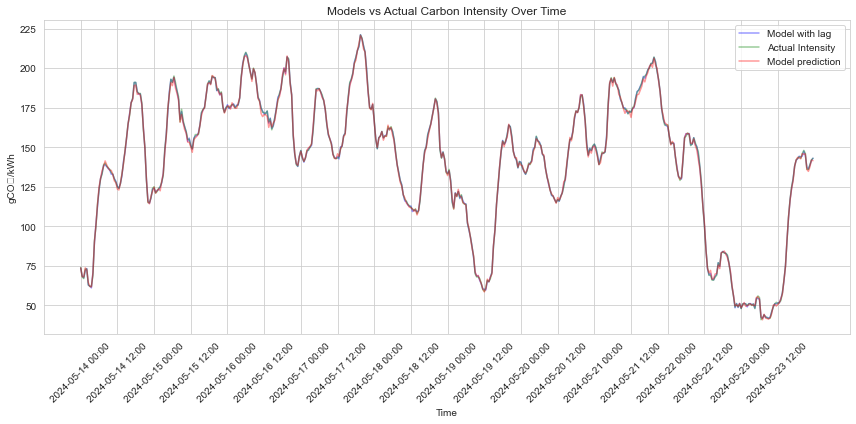

In [15]:
sns.set_style('whitegrid')

test_set.index = pd.to_datetime(test_set.index)#Currently index isn't datetime

# Plot lines
fig,ax = plt.subplots(figsize=(12, 6))
sns.lineplot(x=test_set.index, y=y_lpred, label='Model with lag', color='blue', alpha=0.4, ax=ax)
sns.lineplot(x=test_set.index, y='intensity.actual', data=test, label='Actual Intensity', alpha=0.4, color='green',ax=ax)
sns.lineplot(x=test_set.index, y=y_pred, label = 'Model prediction', color='red', alpha=0.4,ax=ax)

import matplotlib.dates as mdates

xticks = test_set.index[::24] # every 12 hours

# Set ticks and formatted tick labels
ax.set_xticks(xticks)
ax.set_xticklabels([ts.strftime('%Y-%m-%d %H:%M') for ts in xticks], rotation=45)

# Label the plot
plt.title('Models vs Actual Carbon Intensity Over Time')
plt.xlabel('Time')
plt.ylabel('gCO₂/kWh')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('Model_vs_Model_wtih_lag_vs_actual.png', dpi=300)
plt.show()

100%|===================| 2819/2829 [05:02<00:01]        

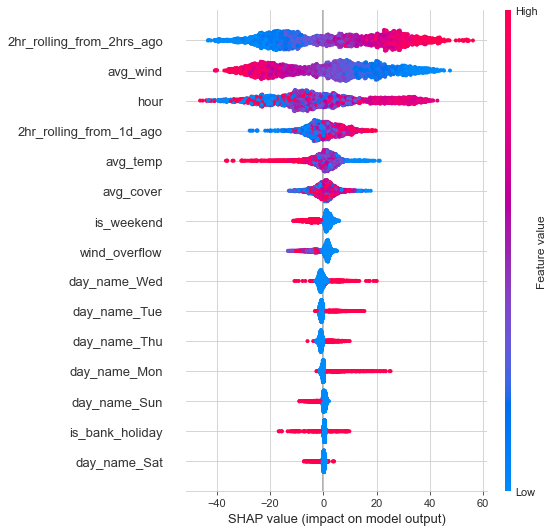

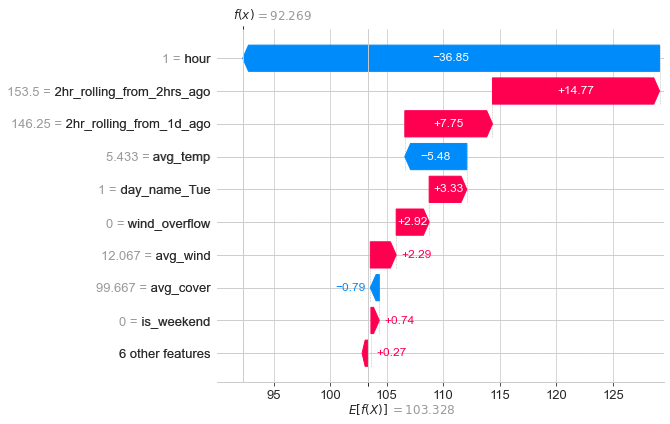

In [16]:
#Explore feature importance with shap
# Explain the model predictions using SHAP
lexplainer = shap.Explainer(best_lmodel, X_ltrain)
shap_lvalues = lexplainer(X_ltrain)

# Summary plot (global importance)
shap.summary_plot(shap_lvalues, X_ltrain)
plt.savefig('shap_summary_with_lag.png', dpi=300, bbox_inches='tight')
plt.close()

# Waterfall plot for a single prediction
shap.plots.waterfall(shap_lvalues[0])
plt.savefig('shap_waterfall_wtih_lag.png', dpi=300, bbox_inches='tight')
plt.close()